# Automated Sleep Stage Classification

## Imports and Setting Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.4 MB/s eta 0:00:00


In [ ]:
# Basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

# MNE
import mne
from mne.datasets.sleep_physionet.age import fetch_data
import torch
mne.set_log_level('ERROR')

In [ ]:
# Model building Helpers
!pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Ensemble Model Preparation
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Accuracy metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc

## Preprocessing

### Data Fetching and Pairing

In [ ]:
destination_directory = '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/'
files_with_paths = []

for file_name in os.listdir(destination_directory):
    full_path = os.path.join(destination_directory, file_name)
    if full_path.lower().endswith('.edf'):
        files_with_paths.append(full_path)

print(files_with_paths)

['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4031E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4021EH-Hypnogram.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4031EC-Hypnogram.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4011EH-Hypnogram.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4001EC-Hypnogram.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4021E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4011E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4041E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4001E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4041EC-Hypnogram.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_

In [ ]:
def group_PSG_Hyno_Pairs(files_with_paths):
    fnames_grouped = {}
    for file in files_with_paths:
        file_name = os.path.basename(file)
        subject_id = file_name[:15]
        file_type = file_name[17:-4]

        if subject_id not in fnames_grouped:
            fnames_grouped[subject_id] = {'PSG': [], 'Hypnogram': []}

        if 'PSG' in file_type:
            fnames_grouped[subject_id]['PSG'].append(file)
        elif 'Hypnogram' in file_type:
            fnames_grouped[subject_id]['Hypnogram'].append(file)
    result = []
    for subject, types in fnames_grouped.items():
        fnames_grouped_for_subject = []
        fnames_grouped_for_subject.extend(types['PSG'])  # Add all PSG files
        fnames_grouped_for_subject.extend(types['Hypnogram'])  # Add all Hypnogram files
        result.append(fnames_grouped_for_subject)
    return result

fnames_grouped = group_PSG_Hyno_Pairs(files_with_paths)
print(fnames_grouped)

[['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4031E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4031EC-Hypnogram.edf'], ['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4021E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4021EH-Hypnogram.edf'], ['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4011E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4011EH-Hypnogram.edf'], ['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4001E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4001EC-Hypnogram.edf'], ['/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4041E0-PSG.edf', '/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Copy of SC4041EC-Hypnogram.edf'], ['/content/drive/MyDrive/Colab_Notebook

### Loading Data and removing extra channels

In [ ]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only = True, crop_wake_mins = 30):
  mapping = {'EOG horizontal': 'eog',
             'Resp oro-nasal': 'misc',
             'EMG submental': 'misc',
             'Temp rectal': 'misc',
             'Event marker': 'misc'}
  exclude_channels = mapping.keys() if load_eeg_only else ()
  raw_data = mne.io.read_raw_edf(raw_fname, exclude = exclude_channels)
  data_annotations = mne.read_annotations(annot_fname)

  raw_data.set_annotations(data_annotations)

  if not load_eeg_only:
    raw_data.set_channel_types(mapping)

  wake_crop_vector = ['1', '2', '3', '4', 'R']
  if crop_wake_mins > 0:
    sleep_stage_inds = []
    sleep_true_store = []
    for x in data_annotations.description:
      if x[-1] in wake_crop_vector:
        sleep_true_store.append(True)
      else:
        sleep_true_store.append(False)

    sleep_stage_inds = np.where(sleep_true_store)[0]
    tmin = data_annotations[int(sleep_stage_inds[0])]['onset'] - crop_wake_mins * 60
    tmax = data_annotations[int(sleep_stage_inds[-1])]['onset'] + crop_wake_mins * 60

    raw_data.crop(tmin = tmin, tmax = tmax)

  ch_names = {i: i.replace('EEG ', '')
              for i in raw_data.ch_names if 'EEG' in i}
  mne.rename_channels(raw_data.info, ch_names)
  basename = os.path.basename(raw_fname)
  # ../../Research_Coding/EEG_Data/Copy of SC4041E0-PSG.edf
  # ../../Research_Coding/EEG_Data/Copy of SC4151EC-Hypnogram.edf
  subj_nb, rec_nb = (basename[10:14]), int(basename[15])
  raw_data.info['subject_info'] = {'his_id': subj_nb, 'id': rec_nb}
  return raw_data

In [ ]:
data_raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames_grouped]

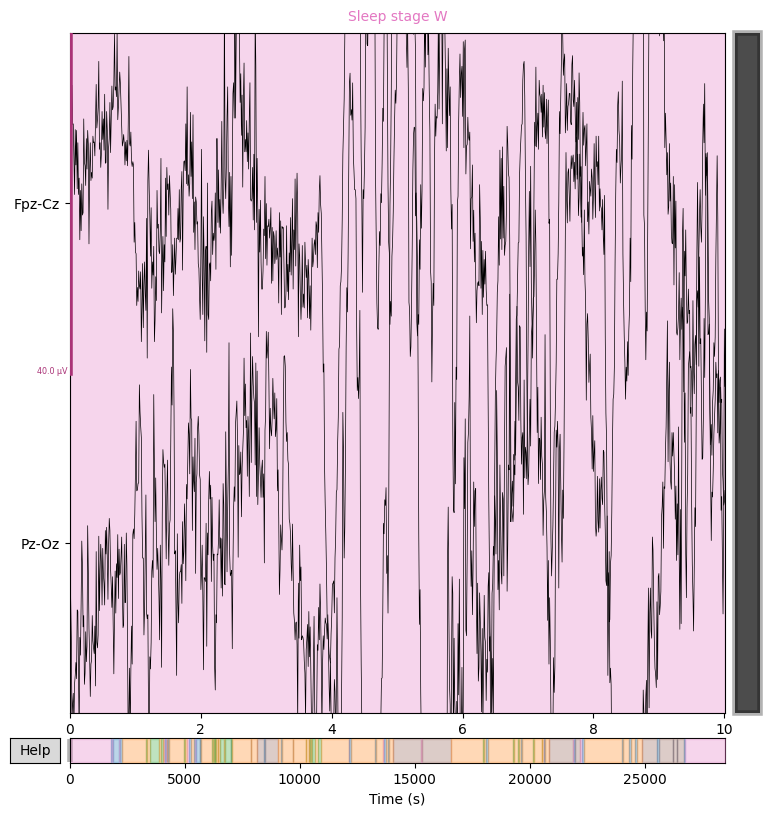

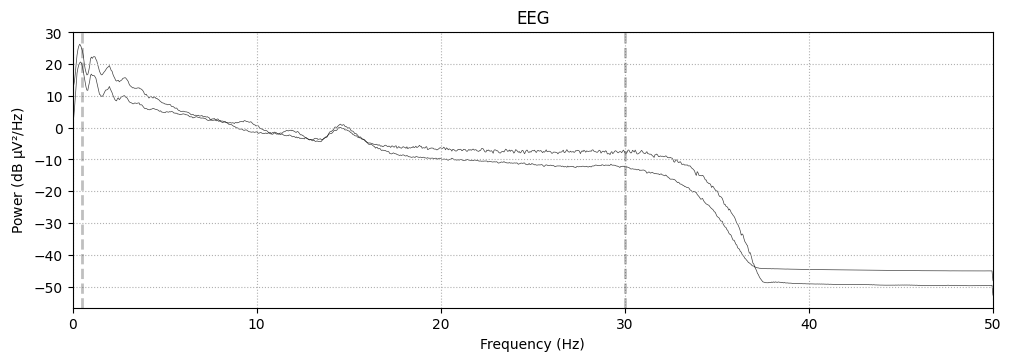

In [ ]:
data_raws[0].plot();
l_freq, h_freq = 0, 30

for raw in data_raws:
    raw.load_data().filter(l_freq, h_freq)

data_raws[2].plot_psd();

### Epoch Creation

In [ ]:
# here in events the first col denote sample time start
# like (2619000, 0, 1)
# upon observation for every 30 sec there is an increment of 3000 in the first value
# this is observed by using the make_fixed_size_events

def event_maker(eventsFromAnnots):
    newEvents = []
    start = eventsFromAnnots[0, 0]
    index = 0
    end = eventsFromAnnots[-1, 0]
    while start < end + 3000:
        if index >= len(eventsFromAnnots):
            break
        if index + 1 < len(eventsFromAnnots) and start == eventsFromAnnots[index + 1, 0]:
            index += 1
        currEvent = [start, 0, eventsFromAnnots[index, 2]]
        newEvents.append(currEvent)
        start += 3000
    return np.array(newEvents)

In [ ]:
# Original Epoch_Creation Function

def epoch_creation(raw_data_list, epoch_length=30):
    epochs_list = []
    labels = []
    for raw in raw_data_list:
        sfreq = int(raw.info['sfreq'])
        annots = raw.annotations

        n_events, event_ids = mne.events_from_annotations(raw)
        events = event_maker(n_events)

        sleep_stage_ids = [1, 2, 3, 4, 5]
        filtered_events = [event for event in events if event[2] in sleep_stage_ids]
        filtered_event_ids = {key: value for key, value in event_ids.items() if value in sleep_stage_ids}

        filtered_events = np.array(filtered_events, dtype=int)

        if filtered_events.ndim != 2 or filtered_events.shape[1] != 3:
            raise ValueError(f"filtered_events must be of shape (N, 3), got {filtered_events.shape}")
        epochs = mne.Epochs(raw, filtered_events, event_id=filtered_event_ids, tmin=0, tmax=epoch_length - 1 / sfreq, baseline=None, preload=True)
        epochs_list.append(epochs)

        stage_mapping = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
        labels.extend([stage_mapping[event[2]] for event in filtered_events])

    return epochs_list, labels

In [ ]:
# This is done using make_fixed_length_events function
# however the issue is it directly puts default value of 1 in event code
# unlike when using event from annotation
fixed_events = mne.make_fixed_length_events(data_raws[7], duration=30)
print(fixed_events)
print(fixed_events.shape[:50])

# this however gives the total number of (30 second) events there would be in said patient's record
# here in patient 7's record there are a total of 969 30-sec events

[[2619000       0       1]
 [2622000       0       1]
 [2625000       0       1]
 ...
 [5517000       0       1]
 [5520000       0       1]
 [5523000       0       1]]
(969, 3)


In [ ]:
# this is the original function method where we get the events
# these however aren't divideed properly
events_found = mne.events_from_annotations(data_raws[7])
print(events_found)
print(events_found[0].shape)

# here i have sent the event lilst got from above to event maker fucntion
# refer the above function for the functioning
new_events = event_maker(events_found[0])
print(new_events[:100])
print(new_events.shape)

(array([[2619000,       0,       6],
       [2799000,       0,       1],
       [2865000,       0,       2],
       [2892000,       0,       1],
       [2898000,       0,       2],
       [2949000,       0,       3],
       [2985000,       0,       4],
       [2988000,       0,       3],
       [2997000,       0,       4],
       [3000000,       0,       3],
       [3012000,       0,       4],
       [3030000,       0,       3],
       [3033000,       0,       4],
       [3039000,       0,       3],
       [3042000,       0,       1],
       [3054000,       0,       2],
       [3111000,       0,       3],
       [3123000,       0,       2],
       [3129000,       0,       3],
       [3132000,       0,       2],
       [3150000,       0,       5],
       [3234000,       0,       1],
       [3252000,       0,       2],
       [3321000,       0,       3],
       [3339000,       0,       4],
       [3351000,       0,       3],
       [3354000,       0,       4],
       [3381000,       0,  

### Evaluation and Plotting Functions


In [ ]:
def save_plot(fig, model_name, plot_type):
    base_dir = "/content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results"
    model_dir = os.path.join(base_dir, model_name)
    # Create directories if they don't exist
    os.makedirs(model_dir, exist_ok=True)
    file_path = os.path.join(model_dir, f"{plot_type}.png")

    # Save figure at 300 DPI
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {file_path}")

In [ ]:
def plotting_auc_roc_curve(y_test, y_pred_probs, stage_names, model_name = "Classifier"):
    n_classes = len(stage_names)
    fig, ax = plt.subplots(figsize=(10, 7))

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{stage_names[i]} (AUC = {roc_auc:.2f})')

    # Plot diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', lw=2)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'AUC-ROC Curve ({model_name})')
    ax.legend(loc='lower right')

    # Save high-quality image
    save_plot(fig, model_name, "AUC_ROC")
    plt.show()

In [ ]:
def evaluate_classifier(y_test, y_pred, class_names, model_name="Classifier"):
    # Compute accuracy, confusion mat and classifcation report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print evaluation metrics
    print(f"{model_name} Accuracy: {accuracy:.3f}")
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{model_name} Confusion Matrix')
    save_plot(fig, model_name, "Confusion_Matrix")
    plt.show()

    # Return results as a dictionary
    return {
        "accuracy": accuracy,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix
    }


## Model Preparation

In [ ]:
Epoch_List, Labels = epoch_creation(data_raws[:12])
print("Number of epochs:", len(Labels))

all_epochs_data = np.concatenate([epochs.get_data() for epochs in Epoch_List], axis=0)
n_epochs, n_channels, n_times = all_epochs_data.shape
print("Number of epochs:", n_epochs)
print("Number of channels:", n_channels)
print("Number of times:", n_times)
print(f"Shape of all_epochs_data: {all_epochs_data.shape}")

X = all_epochs_data.reshape((n_epochs, n_channels * n_times))
y = np.array(Labels)
y = (y - 1).astype(int)
stage_names = ['W', 'N1', 'N2', 'N3', 'REM']
print("Label distribution:", np.bincount(y))

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


Number of epochs: 9682
Number of epochs: 9682
Number of channels: 2
Number of times: 3000
Shape of all_epochs_data: (9682, 2, 3000)
Label distribution: [ 696 4276 2006  829 1875]


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14966, 6000)
(6414, 6000)
(14966,)
(6414,)


## Simple Models

DecisionTreeClassifier Accuracy: 0.544

DecisionTreeClassifier Classification Report:

              precision    recall  f1-score   support

           W       0.63      0.69      0.66      1289
          N1       0.36      0.31      0.33      1268
          N2       0.48      0.44      0.46      1277
          N3       0.76      0.72      0.74      1308
         REM       0.47      0.55      0.51      1272

    accuracy                           0.54      6414
   macro avg       0.54      0.54      0.54      6414
weighted avg       0.54      0.54      0.54      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/DecisionTreeClassifier/Confusion_Matrix.png


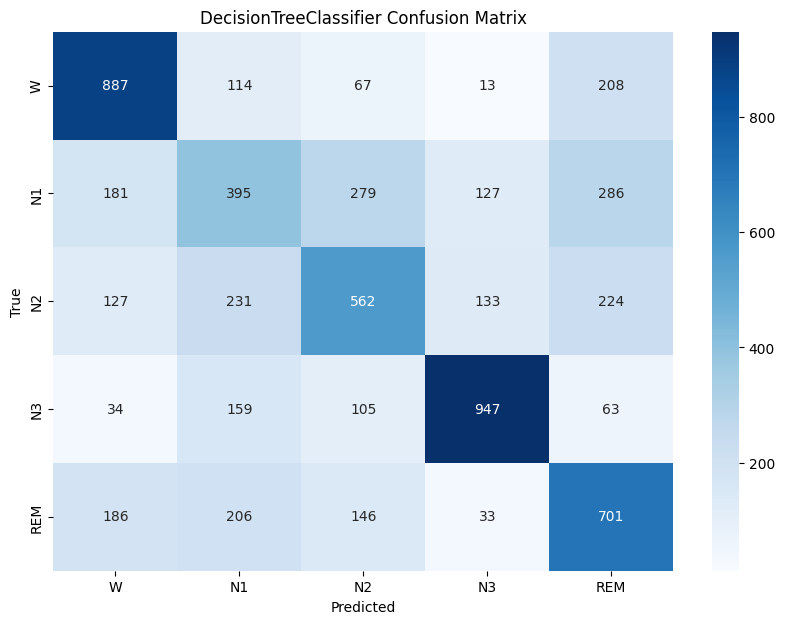

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/DecisionTreeClassifier/AUC_ROC.png


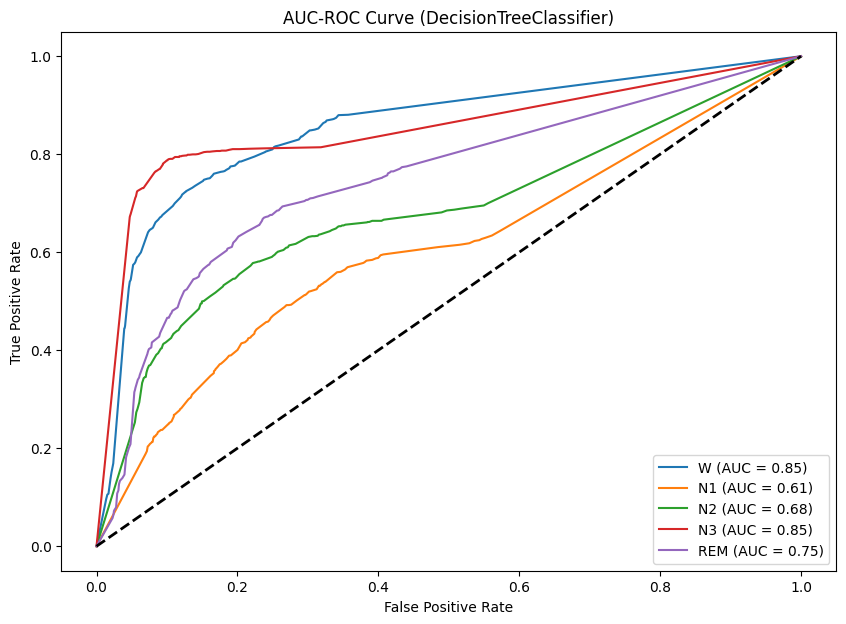

In [ ]:
# Decision Tree model
clf_dt = DecisionTreeClassifier(
    criterion='gini', max_depth=15, min_samples_split=5,
    min_samples_leaf=3,random_state=42
)

# Train the model
clf_dt.fit(X_train, y_train)

# Predict on test set
y_pred_dt = clf_dt.predict(X_test)
y_pred_probs_dt = clf_dt.predict_proba(X_test)

# Evaluate performance
evaluate_classifier(y_test, y_pred_dt, stage_names, model_name="DecisionTreeClassifier")
plotting_auc_roc_curve(y_test, y_pred_probs_dt, stage_names, model_name="DecisionTreeClassifier")


SupportVectorClassifier Accuracy: 0.864

SupportVectorClassifier Classification Report:

              precision    recall  f1-score   support

           W       0.93      0.98      0.96      1289
          N1       0.78      0.67      0.72      1268
          N2       0.85      0.81      0.83      1277
          N3       0.87      0.99      0.93      1308
         REM       0.87      0.87      0.87      1272

    accuracy                           0.86      6414
   macro avg       0.86      0.86      0.86      6414
weighted avg       0.86      0.86      0.86      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/SupportVectorClassifier/Confusion_Matrix.png


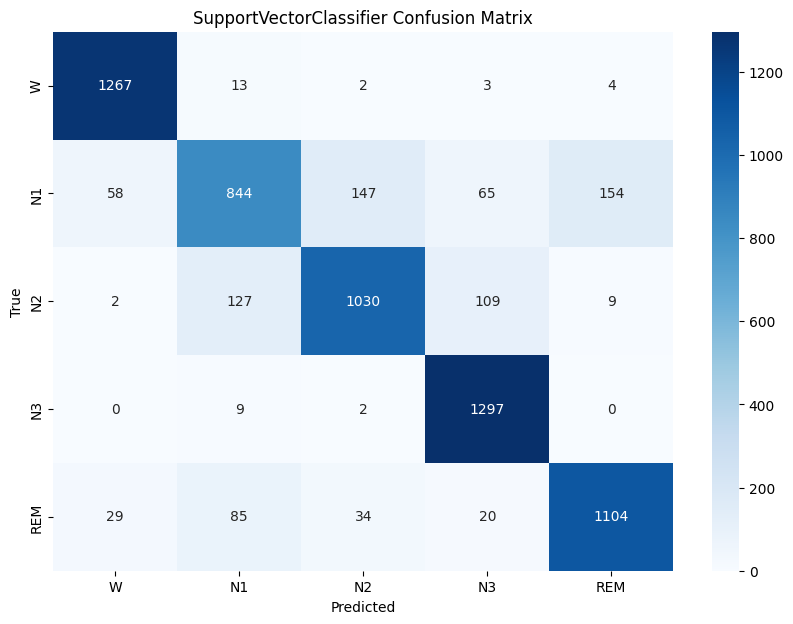

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/SupportVectorClassifier/AUC_ROC.png


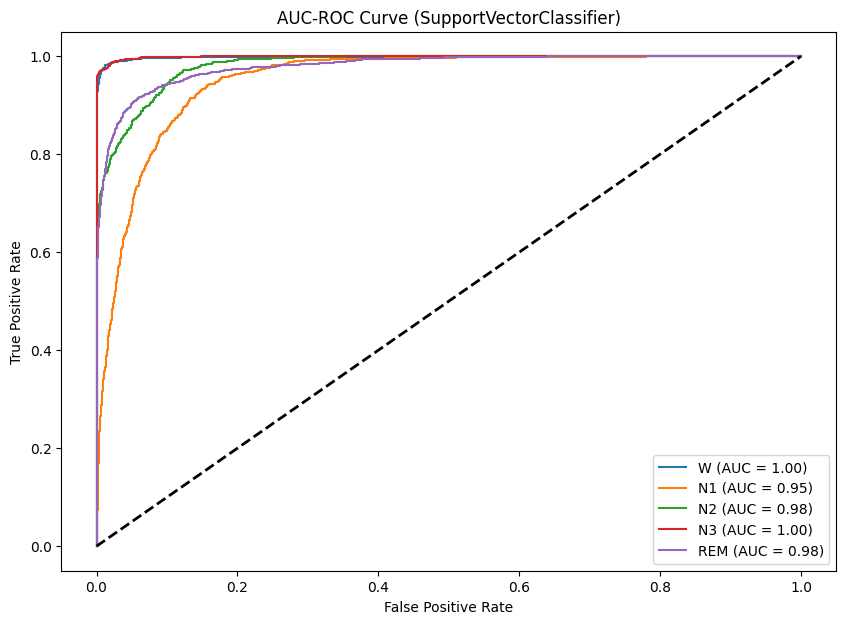

In [ ]:
# SVM Model
clf_svm = SVC(kernel='rbf', C=20, probability=True, random_state=42, cache_size=1000)
clf_svm.fit(X_train, y_train)

# Predict on the test set + evaluation
y_pred_svm = clf_svm.predict(X_test)
y_pred_probs_svm = clf_svm.predict_proba(X_test)

svm_result = evaluate_classifier(y_test, y_pred_svm, stage_names, model_name="SupportVectorClassifier")
plotting_auc_roc_curve(y_test, y_pred_probs_svm, stage_names, model_name="SupportVectorClassifier")

RandomForestClassifier Accuracy: 0.817

RandomForestClassifier Classification Report:

              precision    recall  f1-score   support

           W       0.98      0.94      0.96      1289
          N1       0.66      0.68      0.67      1268
          N2       0.82      0.67      0.74      1277
          N3       0.83      0.99      0.90      1308
         REM       0.81      0.80      0.81      1272

    accuracy                           0.82      6414
   macro avg       0.82      0.82      0.81      6414
weighted avg       0.82      0.82      0.82      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/RandomForestClassifier/Confusion_Matrix.png


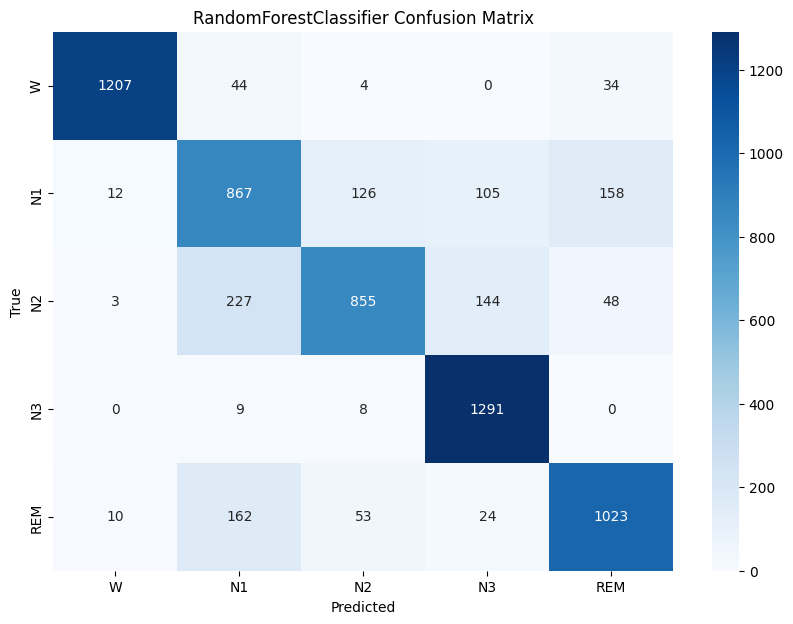

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/RandomForestClassifier/AUC_ROC.png


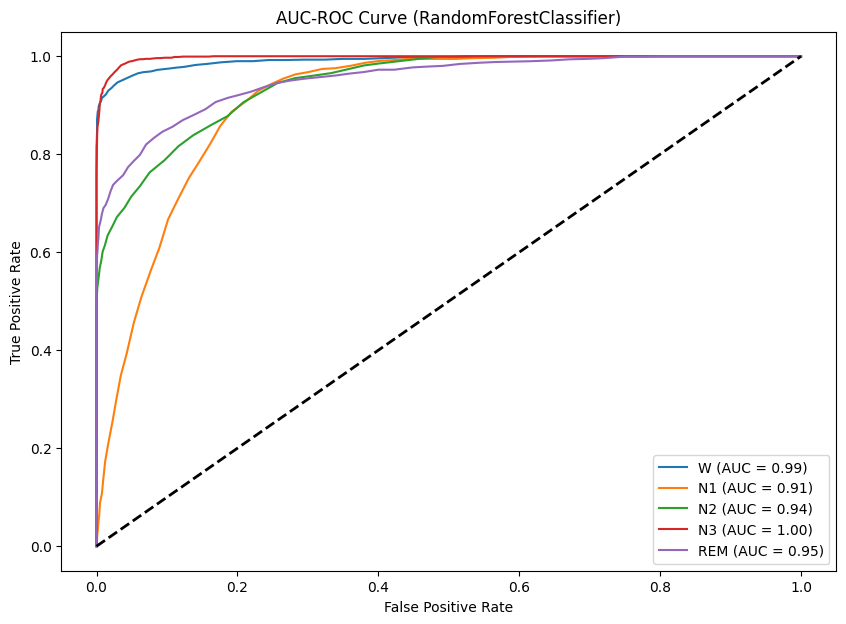

In [ ]:
# Random Forest
clf = RandomForestClassifier(n_estimators=151, random_state=42)
clf.fit(X_train, y_train)

# Prediction on test set + evaluation
y_pred_rf = clf.predict(X_test)
y_pred_probs_rf = clf.predict_proba(X_test)

rf_result = evaluate_classifier(y_test, y_pred_rf, stage_names, model_name="RandomForestClassifier")
plotting_auc_roc_curve(y_test, y_pred_probs_rf, stage_names, model_name="RandomForestClassifier")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:32:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoostClassifier Accuracy: 0.843

XGBoostClassifier Classification Report:

              precision    recall  f1-score   support

           W       0.96      0.95      0.96      1289
          N1       0.68      0.75      0.71      1268
          N2       0.83      0.72      0.77      1277
          N3       0.90      0.98      0.94      1308
         REM       0.84      0.81      0.82      1272

    accuracy                           0.84      6414
   macro avg       0.84      0.84      0.84      6414
weighted avg       0.84      0.84      0.84      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/XGBoostClassifier/Confusion_Matrix.png


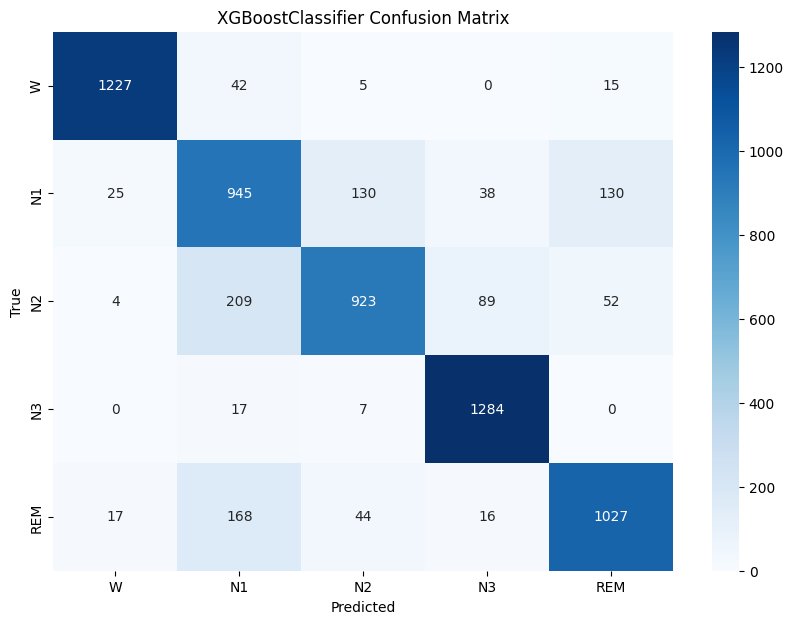

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/XGBoostClassifier/AUC_ROC.png


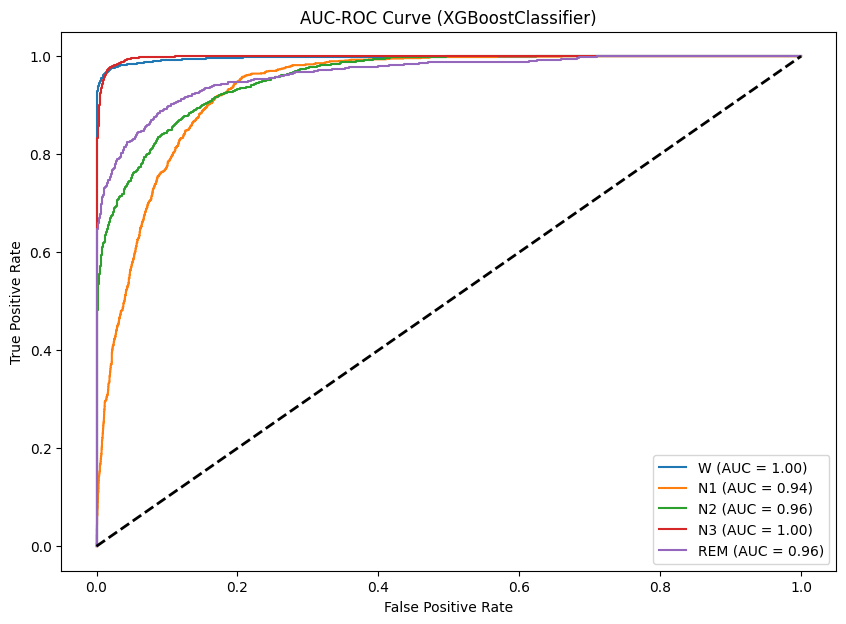

In [ ]:
# XGBoost Classifier
clf_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
clf_xgb.fit(X_train, y_train)

# Prediction on test set + evaluation
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_probs_xgb = clf_xgb.predict_proba(X_test)

xgb_result = evaluate_classifier(y_test, y_pred_xgb, stage_names, model_name="XGBoostClassifier")
plotting_auc_roc_curve(y_test, y_pred_probs_xgb, stage_names, model_name="XGBoostClassifier")

## Ensemble Models

In [ ]:
# Best Models
best_svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42, cache_size=1000)

best_rf = RandomForestClassifier(
    n_estimators=151, min_samples_split=2, min_samples_leaf=1,
    max_depth=15, bootstrap=False, random_state=42
)

best_dt = DecisionTreeClassifier(
    criterion='gini', max_depth=15, min_samples_split=5,
    min_samples_leaf=3,random_state=42
)

best_xgb = XGBClassifier(
    colsample_bytree=0.6927, gamma=0.00798, learning_rate=0.0793,
    max_depth=6, n_estimators=160, subsample=0.8416,
    random_state=42, use_label_encoder=False, eval_metric='mlogloss'
)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:58:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble_Voting_Classifier_1_Hard Accuracy: 0.862

Ensemble_Voting_Classifier_1_Hard Classification Report:

              precision    recall  f1-score   support

           W       0.95      0.95      0.95      1289
          N1       0.72      0.81      0.76      1268
          N2       0.94      0.72      0.81      1277
          N3       0.88      0.99      0.93      1308
         REM       0.87      0.84      0.85      1272

    accuracy                           0.86      6414
   macro avg       0.87      0.86      0.86      6414
weighted avg       0.87      0.86      0.86      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Ensemble_Voting_Classifier_1_Hard/Confusion_Matrix.png


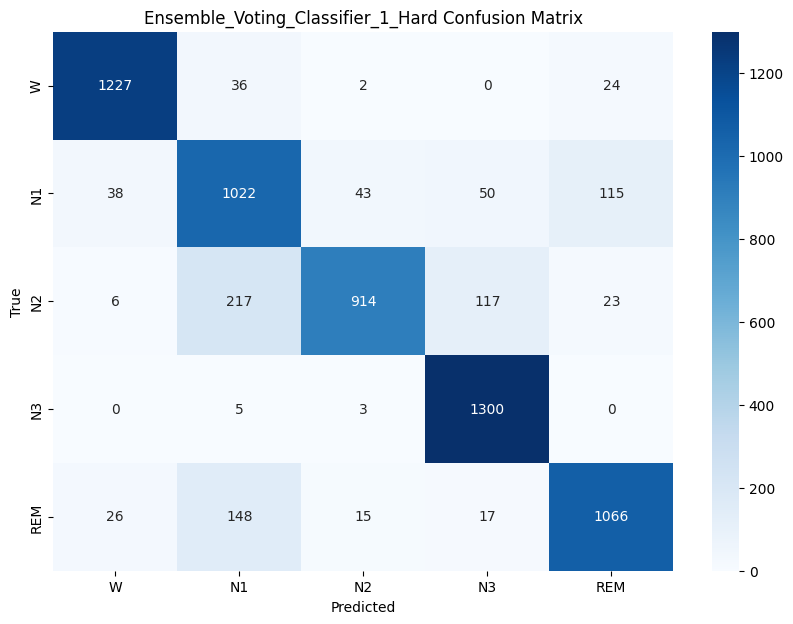

In [ ]:
# Ensemble (SVM + XGB + RF)
ensemble_clf1 = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='hard'
)

# Train ensemble model.
ensemble_clf1.fit(X_train, y_train)

# Predict on the test set + evaluation
y_pred_ensemble1 = ensemble_clf1.predict(X_test)

ens1_result = evaluate_classifier(y_test, y_pred_ensemble1, stage_names, model_name="Ensemble_Voting_Classifier_1_Hard")

Ensemble_Voting_Classifier_SVM_RF_Soft Accuracy: 0.885

Ensemble_Voting_Classifier_SVM_RF_Soft Classification Report:

              precision    recall  f1-score   support

           W       0.97      0.98      0.97      1289
          N1       0.76      0.78      0.77      1268
          N2       0.87      0.82      0.84      1277
          N3       0.94      0.99      0.96      1308
         REM       0.88      0.86      0.87      1272

    accuracy                           0.88      6414
   macro avg       0.88      0.88      0.88      6414
weighted avg       0.88      0.88      0.88      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Ensemble_Voting_Classifier_SVM_RF_Soft/Confusion_Matrix.png


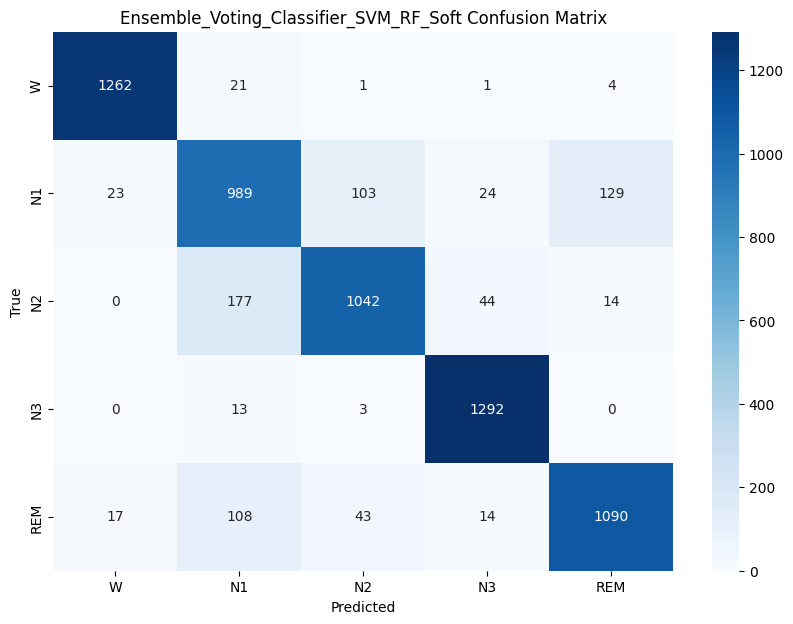

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Ensemble_Voting_Classifier_SVM_RF_Soft/AUC_ROC.png


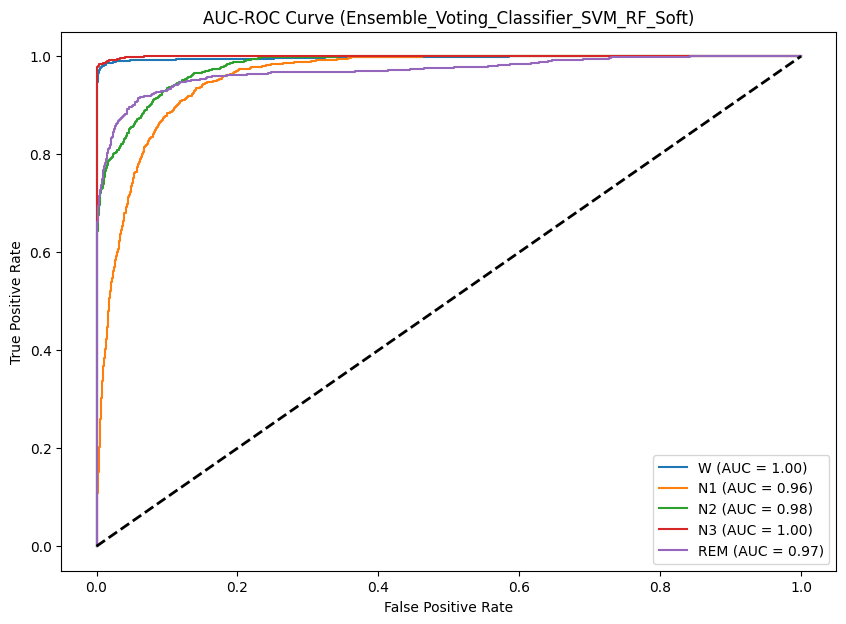

In [ ]:
# Ensemble (SVM + RF)
ensemble_clf2 = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf)
    ],
    voting='soft'
)

# Train ensemble model.
ensemble_clf2.fit(X_train, y_train)

# Predict on the test set + evaluation
y_pred_ensemble2 = ensemble_clf2.predict(X_test)
y_pred_prob_ensemble2 = ensemble_clf2.predict_proba(X_test)

ens2_result = evaluate_classifier(y_test, y_pred_ensemble2, stage_names, model_name="Ensemble_Voting_Classifier_SVM_RF_Soft")
plotting_auc_roc_curve(y_test, y_pred_prob_ensemble2, stage_names, model_name="Ensemble_Voting_Classifier_SVM_RF_Soft")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:41:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble_Voting_Classifier_1_Soft Accuracy: 0.874

Ensemble_Voting_Classifier_1_Soft Classification Report:

              precision    recall  f1-score   support

           W       0.97      0.96      0.96      1289
          N1       0.71      0.81      0.76      1268
          N2       0.88      0.77      0.82      1277
          N3       0.94      0.99      0.96      1308
         REM       0.88      0.84      0.86      1272

    accuracy                           0.87      6414
   macro avg       0.88      0.87      0.87      6414
weighted avg       0.88      0.87      0.87      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Ensemble_Voting_Classifier_1_Soft/Confusion_Matrix.png


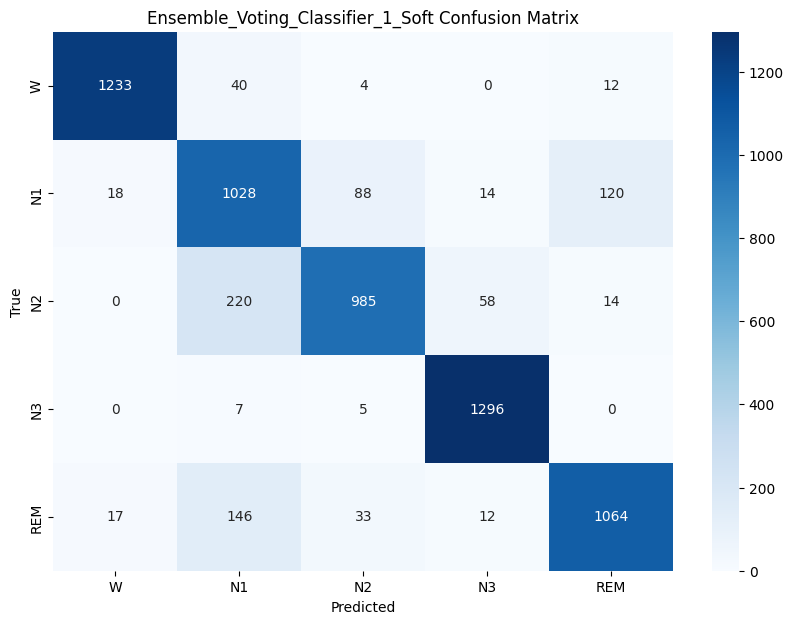

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Ensemble_Voting_Classifier_1_Soft/AUC_ROC.png


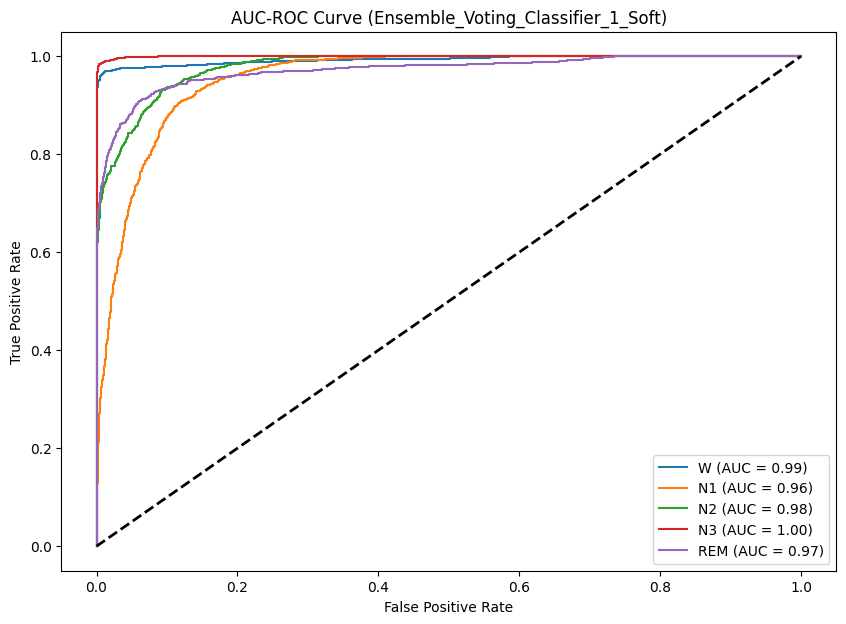

In [ ]:
# Ensemble (SVM + XGB + RF)
ensemble_clf4 = VotingClassifier(
    estimators=[
        ('svm', best_svm),
        ('rf', best_rf),
        ('xgb', best_xgb)
    ],
    voting='soft'
)

# Train ensemble model.
ensemble_clf4.fit(X_train, y_train)

# Predict on the test set + evaluation
y_pred_ensemble4 = ensemble_clf4.predict(X_test)
ens4_result = evaluate_classifier(y_test, y_pred_ensemble4, stage_names, model_name="Ensemble_Voting_Classifier_1_Soft")

y_pred_prob_ensemble4 = ensemble_clf4.predict_proba(X_test)
plotting_auc_roc_curve(y_test, y_pred_prob_ensemble4, stage_names, model_name="Ensemble_Voting_Classifier_1_Soft")

Bagging SVM Accuracy: 0.549

Bagging SVM Classification Report:

              precision    recall  f1-score   support

           W       0.63      0.69      0.66      1289
          N1       0.36      0.31      0.33      1268
          N2       0.49      0.45      0.47      1277
          N3       0.75      0.74      0.74      1308
         REM       0.48      0.55      0.51      1272

    accuracy                           0.55      6414
   macro avg       0.54      0.55      0.54      6414
weighted avg       0.54      0.55      0.55      6414

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Bagging SVM/Confusion_Matrix.png


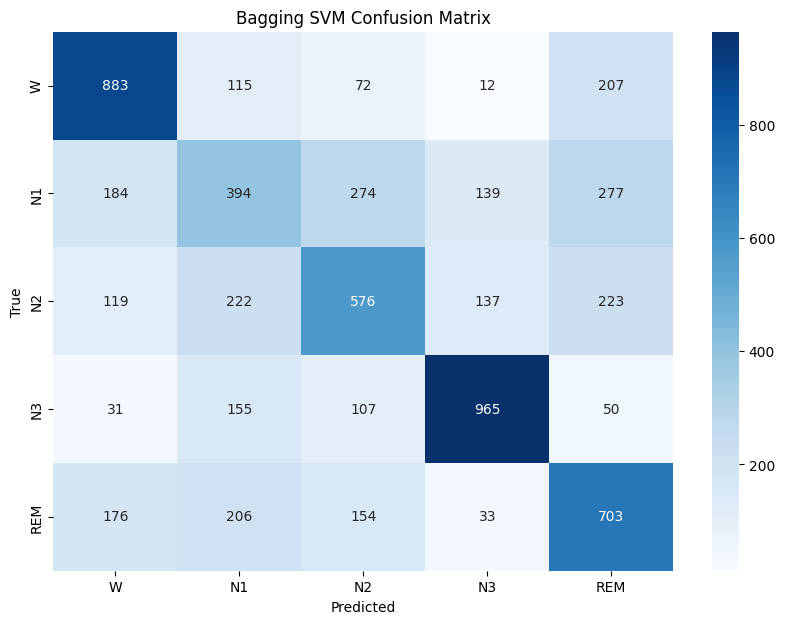

Saved: /content/drive/MyDrive/Colab_Notebooks/Research_Coding/EEG_Data/Results/Bagging SVM/AUC_ROC.png


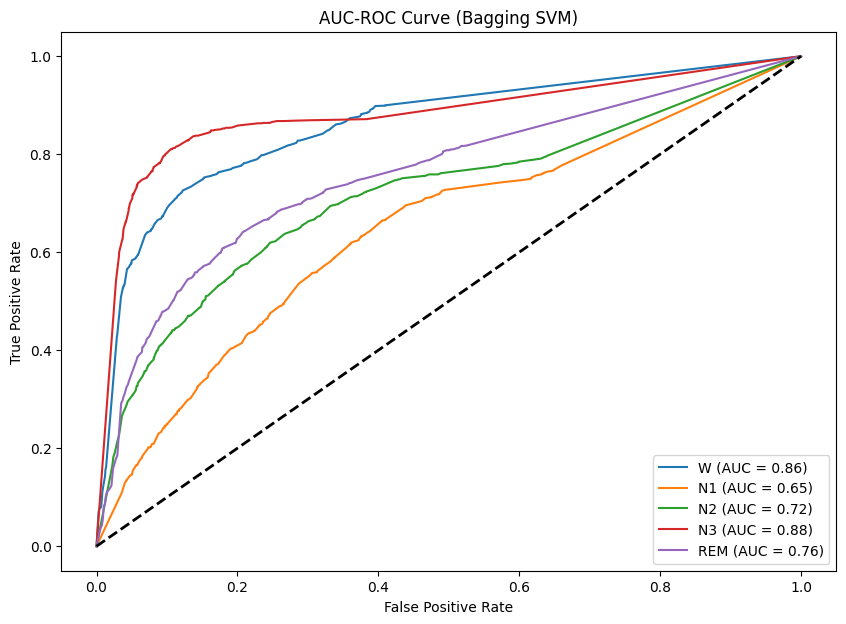

In [ ]:
# Bagging Classifier using SVM as base
bagging_dt = BaggingClassifier(estimator=best_dt, n_estimators=8, random_state=42, n_jobs=-1, bootstrap=False)

# Training Model
bagging_dt.fit(X_train, y_train)

# Predict on test set + evaluation
y_pred_bagging_dt = bagging_dt.predict(X_test)
y_pred_probs_bagging_dt = bagging_dt.predict_proba(X_test)

bag_svm = evaluate_classifier(y_test, y_pred_bagging_dt, stage_names, model_name="Bagging SVM")
plotting_auc_roc_curve(y_test, y_pred_probs_bagging_dt, stage_names, model_name="Bagging SVM")